## Import dataset

In [1]:
from datasets import load_dataset

category = 'py'
df = load_dataset('JetBrains-Research/template-generation', category, split='dev')

In [2]:
import ast

df = df.map(lambda example: {'topics': ast.literal_eval(example['topics'])}, batched=False)


## Select only 'fastapi', 'django', 'flask' exaples 

In [3]:
topics_to_check = ['fastapi', 'flask']


def classify_by_topic(dp):
    class_topic = None
    
    for topic in dp['topics']:
        if topic in topics_to_check:
            if class_topic is None:
                class_topic = topic
            else:
                return {'class_topic': None}

    return {'class_topic': class_topic}


def class_topic_not_none(example):
    return example['class_topic'] is not None


df = df.map(classify_by_topic)
df = df.filter(class_topic_not_none)

In [4]:
df

Dataset({
    features: ['id', 'full_name', 'owner', 'name', 'html_url', 'is_template', 'description', 'template_keywords', 'license', 'topics', 'size', 'metrics', 'languages', 'language', 'created_at', 'updated_at', 'code_lines', 'gpt_description', 'class_topic'],
    num_rows: 75
})

In [5]:
from collections import Counter

Counter(df['class_topic'])

Counter({'fastapi': 46, 'flask': 29})

In [40]:
subset = {topic: [] for topic in topics_to_check}

n_exampels = 3
for dp in df.shuffle(2):
    topic = dp['class_topic']

    if len(subset[topic]) < n_exampels:
        subset[topic].append(dp)

In [41]:
from datasets import Dataset
df_s = Dataset.from_list([item for s in subset.values() for item in s]) 

In [42]:
for f in df_s['full_name']:
    print(f'https://github.com/{f}')

https://github.com/cheind/python-hls-stream
https://github.com/jparadadev/python-ddd-skeleton
https://github.com/m0kr4n3/fastapi_project_template
https://github.com/jelmerdejong/flask-app-blueprint
https://github.com/tomimick/restpie3
https://github.com/bigfang/horn-py


In [6]:
df_s = df

## Cloning repos

In [7]:
repos_path = '/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos'

In [8]:
from git import Repo
import os

for dp in df_s:
    repo_path = f'{repos_path}/{"__".join(dp["full_name"].split("/"))}'
    if os.path.exists(repo_path):
        continue
    Repo.clone_from(f'https://github.com/{dp["full_name"]}.git',
                    f'{repos_path}/{"__".join(dp["full_name"].split("/"))}')

## Extract methods

In [9]:
!pip install -U tree-sitter==0.21.3
!pip install tree_sitter_languages

In [10]:
import fnmatch
import os
from tree_sitter_languages import get_language, get_parser

language = get_language('python')
parser = get_parser('python')

def get_nodes_by_type(node, t: str):
    t_nodes = []
    if node.type == t:
        t_nodes.append(node)
    else:
        for child in node.children:
            t_nodes.extend(get_nodes_by_type(child, t))
    return t_nodes


def get_node_content(node, code) -> str:
    start_byte = node.start_byte
    end_byte = node.end_byte
    return code[start_byte:end_byte].decode('utf-8')


def extract_methods_from_code(code: str, language: str):
    node_t_by_language = {
        "py": 'function_definition',
        "java": 'method_declaration'
    }

    t = node_t_by_language[language]
    tree = parser.parse(code)
    all_methods = get_nodes_by_type(tree.root_node, t)
    method_contents = []
    for method in all_methods:
        method_content = get_node_content(method, code)
        method_contents.append(method_content)

    return method_contents


def get_repo_files(directory: str, extension: str):
    for root, dir, files in os.walk(directory):
        for file in files:
            if fnmatch.fnmatch(file, f"*.{extension}"):
                yield os.path.join(root, file)

/Users/Maria.Tigina/PycharmProjects/agents-eval/.venv/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


In [77]:
from sentence_transformers import SentenceTransformer
import numpy as np

vect = {}
for entity in ['files', 'methods', 'requirements']:
    vect[entity] = {
        'content': [],
        'repo': [],
        'path': [],
        'vects': np.empty((0, 1024)),
        'class_topic': []
    }

for dp in df_s:
    repo = dp['full_name']
    repo_path = os.path.join(repos_path, "__".join(dp["full_name"].split("/")))
    requirements_path = os.path.join(repo_path, 'requirements.txt')
    
    for file_path in glob.glob(os.path.join(repo_path, '**/pyproject.toml'), recursive=True):
        with open(file_path, 'r') as f:
            file_content = f.read()
            vect['requirements']['content'].append(file_content)
            vect['requirements']['repo'].append(repo)
            vect['requirements']['path'].append(file_path)
            vect['requirements']['class_topic'].append(dp['class_topic'])

    for file_path in glob.glob(os.path.join(repo_path, '**/requirements.txt'), recursive=True):
        with open(file_path, 'r') as f:
            file_content = f.read()
            vect['requirements']['content'].append(file_content)
            vect['requirements']['repo'].append(repo)
            vect['requirements']['path'].append(file_path)
            vect['requirements']['class_topic'].append(dp['class_topic'])
            
    for file_path in get_repo_files(repo_path, category):
        with open(file_path, 'r') as f:
            file_content = f.read()
            vect['files']['content'].append(file_content)
            vect['files']['repo'].append(repo)
            vect['files']['path'].append(file_path)
            vect['files']['class_topic'].append(dp['class_topic'])

            source_code = bytes(file_content, "utf8")
            methods = extract_methods_from_code(source_code, category)
            for method in methods:
                vect['methods']['content'].append(method)
                vect['methods']['repo'].append(repo)
                vect['methods']['path'].append(file_path)
                vect['methods']['class_topic'].append(dp['class_topic'])

model = SentenceTransformer('thenlper/gte-large')

for entity in ['files', 'methods', 'requirements']:
    vect[entity]['vects'] = model.encode(vect[entity]['content'])
    print(vect[entity]['vects'].shape)
    print(len(vect[entity]['content']))
    print(len(vect[entity]['path']))


(1838, 1024)
1838
1838
(3897, 1024)
3897
3897
(117, 1024)
117
117


In [78]:
import re

vectorizer = TfidfVectorizer()
for entity in ['requirements']:
    vect[entity]['content'] = [re.sub(r'==[0-9]+\.[0-9]+\.[0-9]+', '', content) for content in vect[entity]['content']]
    vect[entity]['vects'] = vectorizer.fit_transform(vect[entity]['content']).toarray()
    print(vect[entity]['vects'].shape)
    print(len(vect[entity]['content']))
    print(len(vect[entity]['path']))

(117, 1234)
117
117


In [79]:
import collections
for entity in ['files', 'methods', 'requirements']:
    print(entity)
    print(collections.Counter(vect[entity]['class_topic']))

files
Counter({'fastapi': 1366, 'flask': 472})
methods
Counter({'fastapi': 2417, 'flask': 1480})
requirements
Counter({'flask': 66, 'fastapi': 51})


In [80]:
from matplotlib.colors import Normalize
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE


def plot_tsne(vects, clusters, labels=None):
    tsne = TSNE(n_components=2, random_state=0)
    methods_tsne = tsne.fit_transform(vects)

    plt.figure(figsize=(5, 5))
    plt.scatter(
        methods_tsne[:, 0],
        methods_tsne[:, 1],
        c=clusters,
        cmap='viridis'
    )

    if labels:
        normalize = Normalize(vmin=min(labels.values()), vmax=max(labels.values()))
        colormap = plt.cm.viridis

        plt.figure(figsize=(2, 2))  # Adjust figure size for better visibility

        for i, repo in enumerate(labels.keys()):
            plt.plot([0, 1], [i, i], color=colormap(normalize(labels[repo])), linewidth=20)

        plt.xticks([])  # Hide x-axis
        plt.yticks(range(len(labels)), labels.keys())  # Show y-axis with labels

    plt.tight_layout()
    plt.show()

In [81]:
import collections
import pandas as pd

def classify(model, entity: str):
    clusters = model.fit_predict(vect[entity]['vects'])
    cluster_counts = collections.Counter(clusters)

    large_clusters = {cluster: count for cluster, count in cluster_counts.items()}
    print(large_clusters)

    labels_mask = clusters != -1
    print(f'Count noise: {np.count_nonzero(labels_mask == False)}')
    repo = np.array(vect[entity]['repo'])
    path = np.array(vect[entity]['path'])
    content = np.array(vect[entity]['content'])
    class_topic = np.array(vect[entity]['class_topic'])
    
    df_labels = pd.DataFrame({
        'label': clusters[labels_mask],
        'repo': repo[labels_mask],
        'path': path[labels_mask], 
        'content': content[labels_mask], 
        'class_topic': class_topic[labels_mask]
    })

    # Clusters plot
    plot_tsne(vect[entity]['vects'], clusters)
    
    for c in large_clusters.keys():
        if c == -1:
            continue
        print(f"Class {c}:")
        # print('repo:', dict(collections.Counter((df_labels[df_labels['label'] == c]['repo']))), sep='\n')
        # print('-------------------------------------------------------------------------------------------')
        print('class_topic:', dict(collections.Counter(df_labels[df_labels['label'] == c]['class_topic'])), sep='\n')
        print('-------------------------------------------------------------------------------------------')
        print('path:', *[p.split('repos/')[1] for p in set(df_labels[df_labels['label'] == c]['path'])], sep='\n')

        # for _, dp in df_labels[df_labels['label'] == c].iterrows():
        #     print(dp['path'].split('repos')[1])
        #     print(dp['content'])
        #     print('-------------------------------------------------------------------------------------------')
        print("===========================================================================================\n")

/var/folders/8f/ywwsn8ws1qz2b22cfcm_q5qw0000gp/T/ipykernel_2237/3505868975.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


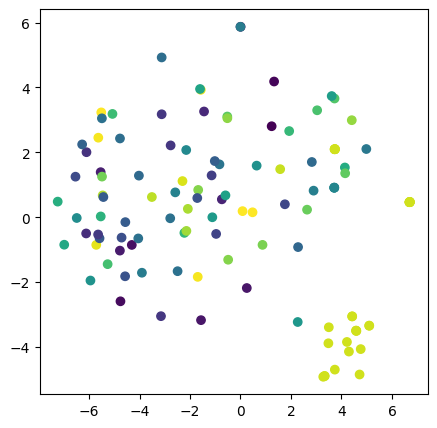

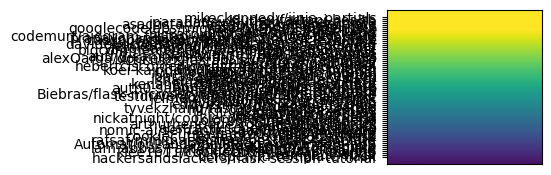

In [82]:
# Actual plot
entity = 'requirements'
actual_labels = {r: i for i, r in enumerate(set(vect[entity]['repo']))}
actual_clusters = np.array([actual_labels[r] for r in vect[entity]['repo']])
plot_tsne(vect[entity]['vects'], actual_clusters, actual_labels)

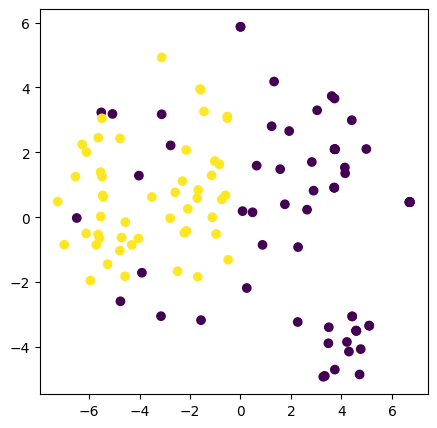

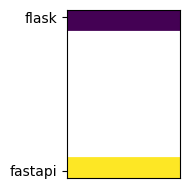

In [83]:
# Actual plot
entity = 'requirements'
actual_labels = {'fastapi': 1, 'flask': 0}
actual_clusters = np.array([1 if c == 'fastapi' else 0 for c in vect[entity]['class_topic']])
plot_tsne(vect[entity]['vects'], actual_clusters, actual_labels)

{-1: 99, 0: 3, 1: 7, 2: 5, 3: 3}
Count noise: 99


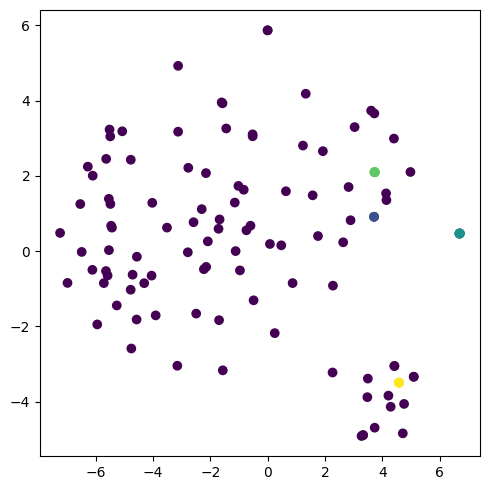

Class 0:
class_topic:
{'flask': 3}
-------------------------------------------------------------------------------------------
path:
Biebras__flask-microservice-architecture-template/services/service_1/requirements.txt
Biebras__flask-microservice-architecture-template/services/service_2/requirements.txt
Biebras__flask-microservice-architecture-template/services/main_service/requirements.txt

Class 1:
class_topic:
{'flask': 7}
-------------------------------------------------------------------------------------------
path:
googlecodelabs__migrate-python2-appengine/mod15b-blobstore/requirements.txt
googlecodelabs__migrate-python2-appengine/mod22-bundled/deferred3/requirements.txt
googlecodelabs__migrate-python2-appengine/mod12b-memcache/requirements.txt
googlecodelabs__migrate-python2-appengine/mod22-bundled/blobstore3/requirements.txt
googlecodelabs__migrate-python2-appengine/mod22-bundled/mail3/requirements.txt
googlecodelabs__migrate-python2-appengine/mod7b-gaetasks/requirements.txt
g

In [84]:
from sklearn.cluster import DBSCAN

# -1 stands for noise
dbscan = DBSCAN(eps=0.08, min_samples=3)
classify(dbscan, entity)

{1: 52, 0: 29}
Count noise: 0


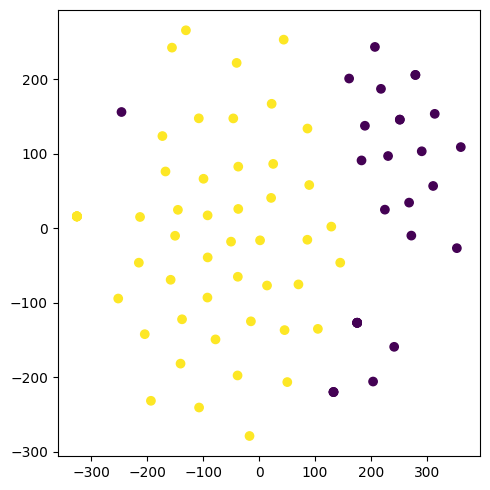

Class 1:
class_topic:
{'flask': 27, 'fastapi': 25}

Class 0:
class_topic:
{'flask': 29}



In [57]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
classify(kmeans, entity)

In [114]:
# top-k libs from req
# fuzzy match node emb = concat content for subtree (for flask)
# =====

{0: 24, 2: 32, 1: 37, 4: 17, 3: 7}
Count noise: 0


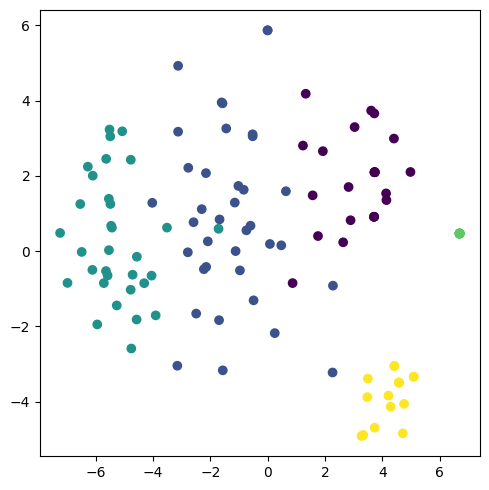

Class 0:
class_topic:
{'flask': 24}
-------------------------------------------------------------------------------------------
path:
abstractkitchen__flask-backbone/requirements.txt
casdoor__casdoor-python-vue-sdk-example/requirements.txt
marcuxyz__mvc-flask/pyproject.toml
ucfopen__lti-template-flask/requirements.txt
googlecodelabs__migrate-python2-appengine/mod12-memcache/requirements.txt
googlecodelabs__migrate-python2-appengine/mod20-gaeusers/requirements.txt
nickjj__docker-flask-example/requirements.txt
rtzll__flask-todolist/requirements.txt
bigcommerce__hello-world-app-python-flask/requirements.txt
googlecodelabs__migrate-python2-appengine/mod18-gaepull/requirements.txt
Biebras__flask-microservice-architecture-template/services/service_2/requirements.txt
Biebras__flask-microservice-architecture-template/services/main_service/requirements.txt
Biebras__flask-microservice-architecture-template/services/service_1/requirements.txt
alexOarga__docker-nginx-flask-celery-mysql-redis/requi

In [86]:
from sklearn.cluster import AgglomerativeClustering

agg_model = AgglomerativeClustering(n_clusters=5)
classify(agg_model, entity)

In [113]:
!tree '/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/abstractkitchen__flask-backbone'

/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/abstractkitchen__flask-backbone
├── LICENSE
├── README.md
├── app
│   ├── __init__.py
│   ├── app.py
│   ├── blueprints
│   │   ├── __boilerplate__
│   │   │   ├── models
│   │   │   │   ├── default.py.template
│   │   │   │   └── with_id.py.template
│   │   │   ├── skeletons
│   │   │   │   └── default
│   │   │   │       ├── __init__.py
│   │   │   │       ├── commands
│   │   │   │       │   └── __init__.py
│   │   │   │       ├── enums
│   │   │   │       │   └── __init__.py
│   │   │   │       ├── models
│   │   │   │       │   └── __init__.py
│   │   │   │       ├── routes.py
│   │   │   │       ├── utils
│   │   │   │       │   └── __init__.py
│   │   │   │       └── views
│   │   │   │           └── __init__.py
│   │   │   └── views
│   │   │       ├── flask_mv
│   │   │       │   ├── routes.py.template
│   │   │       │   └── view.py.template
│   │   │       ├── flask_view
│   │   │       │   ├── routes.py.template
│  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [111]:
def parse_tree(root_path):
    tree_dict = {}
    start_path_len = len(root_path)

    for dirpath, dirnames, filenames in os.walk(root_path):
        if dirpath.startswith(root_path):
            parts = dirpath[start_path_len:].strip(os.sep).split(os.sep)
            current_level = tree_dict
            for part in parts:
                if part not in current_level:
                    current_level[part] = {}
                current_level = current_level[part]

            for dirname in dirnames:
                if dirname not in current_level:
                    current_level[dirname] = {}

            for filename in filenames:
                file_content = None
                try:
                    with open(os.path.join(dirpath, filename), 'r') as f:
                        file_content = f.read()
                except Exception as e:
                    print(e)
                current_level[filename] = file_content

    return tree_dict

In [112]:
parse_tree('/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/abstractkitchen__flask-backbone')

'utf-8' codec can't decode byte 0xdf in position 17: invalid continuation byte
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xba in position 11: invalid start byte


{'': {'app': {},
  'config': {},
  'instance': {},
  '.git': {},
  'configure.py': 'import typing as t\nimport secrets\nimport click\n\nfrom string import Template\n\nfrom app.utils import filesystem\n\n\nAPP_CONFIG_FILE = "instance/config.py"\nINSTANCE_CONFIG_TEXT = """\nSECRET_KEY = "$secret_key"\nSQLALCHEMY_DATABASE_URI = "$sqlalchemy_database_uri"\n"""\n\nDOT_ENV_TEXT = """\nFLASK_DEBUG=1\nAPP_CONFIG=$flask_env\nFLASK_RUN_PORT=$flask_port\n"""\n\n\ndef ask_for_database_uri() -> t.Any:\n    click.echo(click.style("> Let\'s add database support:", fg="green", bold=True))\n    click.echo("""\n        Format: postgresql://<user>:<password>@localhost:5432/<db>\\n\n        Or leave it empty, if you don\'t need database support\n        """)\n\n    return click.prompt("Database URI", default="")\n\n\ndef create_instance_config() -> str:\n    secret_key: str = secrets.token_hex()\n    sqlalchemy_database_uri: t.Any = ask_for_database_uri()\n\n    variables: dict = {\n        "secret_key": 

In [93]:
for dp in df_s:
    repo = dp['full_name']
    repo_path = os.path.join(repos_path, "__".join(dp["full_name"].split("/")))
    print(repo_path)

/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/abstractkitchen__flask-backbone
/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/alefeans__flask-base
/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/alexOarga__docker-nginx-flask-celery-mysql-redis
/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/anthonycepeda__fastapi-mongodb-async-restapi
/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/anthonycepeda__fastapi-sqlmodel
/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/arthurhenrique__cookiecutter-fastapi
/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/asacristani__fastapi-rocket-boilerplate
/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/Atticuszz__fastapi_supabase_template
/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/auth0-samples__auth0-python-api-samples
/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos/auth0-samples__auth0-python-web-app
/Users/Maria.Tigina/PycharmProjects/agent